# Walmart Stores Weekly Sales Forecasting

These dataset provide insights into the complex interplay between external factors, store attributes, and sales trends within the retail ecosystem.

https://www.kaggle.com/datasets/abubakkar123/walmart-stores-weekly-sales-forecasting

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Dataset

**Store:** Unique identifier for each Walmart store.

**Date:** The date corresponding to the weekly sales data.

**Weekly_Sales:** Actual sales for the specific store on the given date.

**Temperature:** Average temperature in the region of the store on the given date.

**Fuel_Price:** Cost of fuel in the region on the given date, influencing consumer spending.

**CPI (Consumer Price Index):** Measure of inflation reflecting average price changes for goods and services.

**Unemployment:** Unemployment rate in the region on the given date, impacting consumer behavior.

**IsHoliday:** Binary indicator denoting whether the week includes a major holiday.

In [4]:
raw = pd.read_csv('data/Walmart.csv')

raw.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
# Create new DataFrame with only rows where 'Store' == 1
store_1 = raw[raw['Store'] == 1] 

store_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 0 to 142
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         143 non-null    int64  
 1   Date          143 non-null    object 
 2   Weekly_Sales  143 non-null    float64
 3   Holiday_Flag  143 non-null    int64  
 4   Temperature   143 non-null    float64
 5   Fuel_Price    143 non-null    float64
 6   CPI           143 non-null    float64
 7   Unemployment  143 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 10.1+ KB


In [7]:
store_1.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [8]:
# Parse with day-first format
store_1['Date'] = pd.to_datetime(store_1['Date'], dayfirst=True)  

# Set as datetime index
store_1.set_index('Date', inplace=True)                           

store_1.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [9]:
# Drop column
store_1 = store_1.drop(columns=['Store'])

store_1.head()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [10]:
store_1.tail()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2012-09-28,1437059.26,0,76.08,3.666,222.981658,6.908
2012-10-05,1670785.97,0,68.55,3.617,223.181477,6.573
2012-10-12,1573072.81,0,62.99,3.601,223.381296,6.573
2012-10-19,1508068.77,0,67.97,3.594,223.425723,6.573
2012-10-26,1493659.74,0,69.16,3.506,223.444251,6.573


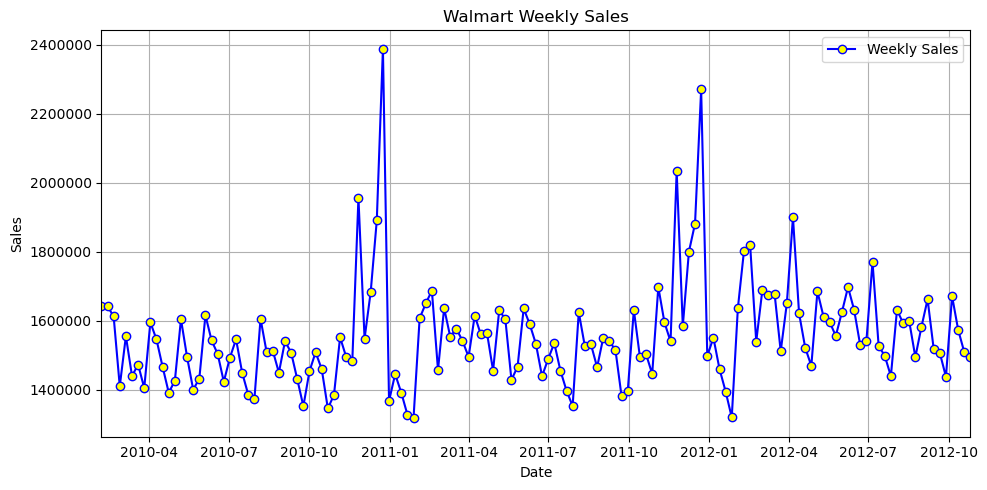

In [11]:
# Plot actual and fitted serie
plt.figure(figsize=(10, 5))                                      

plt.plot(store_1.index, store_1['Weekly_Sales'], label='Weekly Sales', marker='o', markerfacecolor='yellow', color='blue')     

plt.title('Walmart Weekly Sales')                      
plt.xlabel('Date')                                        
plt.ylabel('Sales')  
plt.xlim(pd.to_datetime('2010-02-05'), pd.to_datetime('2012-10-26'))
plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()

In [12]:
# Split the data
cutoff = pd.to_datetime("2012-07-01")

train = store_1[store_1.index < cutoff]
test = store_1[store_1.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (126, 6)
Test shape: (17, 6)

            Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
Date                                                                          
2012-06-01    1624477.58             0        77.95       3.501  221.747214   
2012-06-08    1697230.96             0        78.30       3.452  221.749484   
2012-06-15    1630607.00             0        79.35       3.393  221.762642   
2012-06-22    1527845.81             0        78.39       3.346  221.803021   
2012-06-29    1540421.49             0        84.88       3.286  221.843400   

            Unemployment  
Date                      
2012-06-01         7.143  
2012-06-08         7.143  
2012-06-15         7.143  
2012-06-22         7.143  
2012-06-29         7.143  

            Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
Date                                                                          
2012-07-06    1769854.16             0        81.57    

In [13]:
wal_series = train['Weekly_Sales']

len(wal_series)

126

In [14]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  


d = determine_nonseasonal_d(wal_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -4.8622, p-value = 0.0000

Non-seasonal differencing term (d): 0


In [15]:
def detect_seasonal(series):

    # Apply Fourier Transform
    fourier = np.fft.fft(series - np.mean(series))
    frequencies = np.fft.fftfreq(len(series))

    # Identify the most significant frequency (ignoring the 0 frequency)
    positive_freqs = frequencies[np.where(frequencies > 0)]
    significant_freq = positive_freqs[np.argmax(np.abs(fourier[1:len(positive_freqs)+1]))]

    # Calculate the seasonal period (S)
    S = int(1 / significant_freq)

    return print(f"Detected Seasonal Period: S = {S}")

detect_seasonal(wal_series)

Detected Seasonal Period: S = 63


In [16]:
def detect_top_seasonal_periods(series, top_n=5):
    import numpy as np
    import pandas as pd

    # Remove mean to center the series
    series_detrended = series - np.mean(series)

    # Apply Fourier Transform
    fourier = np.fft.fft(series_detrended)
    frequencies = np.fft.fftfreq(len(series))

    # Only keep positive frequencies (exclude zero)
    positive_mask = frequencies > 0
    positive_freqs = frequencies[positive_mask]
    magnitudes = np.abs(fourier[positive_mask])

    # Get indices of top N magnitudes
    top_indices = np.argsort(magnitudes)[-top_n:][::-1]

    # Prepare result
    top_periods = [(round(1 / positive_freqs[i], 2), magnitudes[i]) for i in top_indices]

    # Display results
    print("Top Seasonal Periods (in time units):")
    for i, (period, magnitude) in enumerate(top_periods, 1):
        print(f"{i}. Period = {period} (Frequency = {round(positive_freqs[top_indices[i-1]], 5)}), Magnitude = {round(magnitude, 2)}")


detect_top_seasonal_periods(wal_series)

Top Seasonal Periods (in time units):
1. Period = 63.0 (Frequency = 0.01587), Magnitude = 4356457.7
2. Period = 12.6 (Frequency = 0.07937), Magnitude = 3603400.06
3. Period = 3.71 (Frequency = 0.26984), Magnitude = 3296109.42
4. Period = 126.0 (Frequency = 0.00794), Magnitude = 3215332.59
5. Period = 25.2 (Frequency = 0.03968), Magnitude = 3063672.18


In [17]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 13, 25, 63]:

    D = determine_seasonal_D(wal_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 13: 0
Seasonal differencing term (D) for 25: 0
Seasonal differencing term (D) for 63: 0


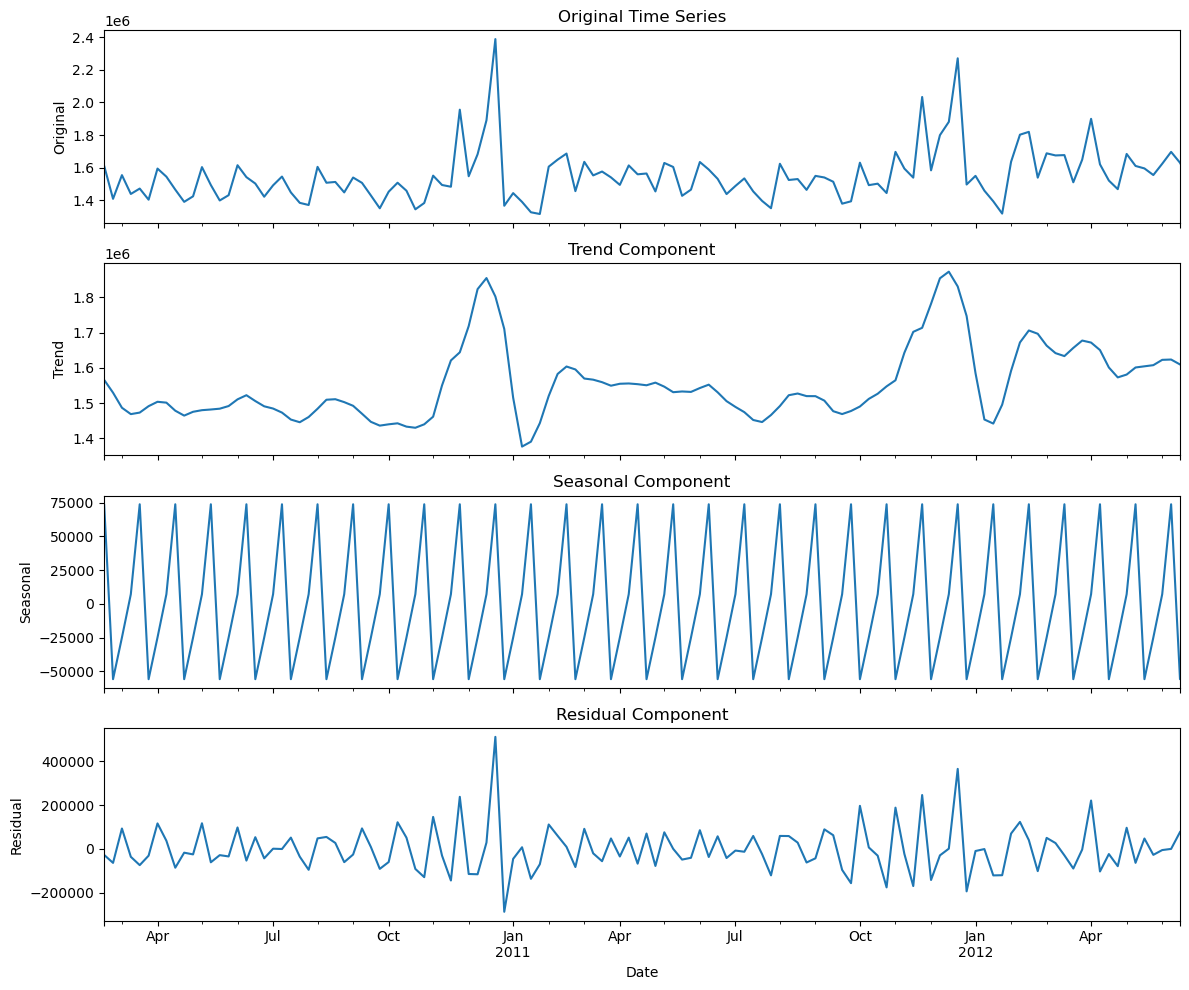

In [18]:
result = seasonal_decompose(wal_series, model='aditive', period=4)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

# SARIMAX

In [19]:
def best_auto_arima(series, d=0, D=0, S=12):

    # Perform a full search over the same grid as your manual SARIMAX model
    auto_model = pm.auto_arima(
        series,                     # The time series data
        seasonal=True,              # Enable seasonal component
        m=S,                        # Seasonal period
        d=d,                        # Set differencing 
        D=D,                        # Set seasonal differencing
        start_p=0, max_p=3,         # p 
        start_q=0, max_q=3,         # q 
        start_P=0, max_P=3,         # P 
        start_Q=0, max_Q=3,         # Q 
        stepwise=False,             # Disable stepwise search (enable full grid search)
        trace=False,                # Print model search progress
        error_action='ignore',      # Ignore errors and continue
        suppress_warnings=True,     # Suppress convergence warnings
        information_criterion='aic' # Use AIC to choose the best model
    )

    # Print the best model found
    print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

best_auto_arima(wal_series, d=0, D=0, S=4)

Best model: SARIMA(3, 0, 1)(0, 0, 1, 4)


In [20]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]       # Generate Cartesian product of input lists
    return combo                                         # Return the list of combinations


def find_best(series, d=0, D=0, S=12):

    P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]              # Define search ranges for non-seasonal parameters (p, q)
    P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]                # Define search ranges for seasonal parameters (P, Q)


    total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
    print(f'Total number of models: {total}')

    vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

    score = {}                                           # Dictionary to store model evaluation metrics

    for i, (p, d, q, P, D, Q) in enumerate(vals):        # Iterate over all parameter combinations
    
        if i % 15 == 0:                                  # Print progress every 15 models
            print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

        m = SARIMAX(series,                              # Define SARIMA model with current parameter set
                    order=(p,d,q), 
                    seasonal_order=(P, D, Q, S),   
                    enforce_stationarity=False)          # Allow non-stationary models for broader search

        res = m.fit(disp=0, low_memory=True)             # Fit the model silently

        score[i] = {                                     # Store model results and evaluation metrics
            'non-seasonal order': (p, d, q),      
            'seasonal order': (P, D, Q),
            'AIC': res.aic,                              # Akaike Information Criterion
        }
        
    print("\nBest models by AIC:")
    best_models = pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()
    print(best_models)


find_best(series=wal_series, d=0, D=0, S=4)

Total number of models: 256
Running model #0 using SARIMA(0,0,0)(0,0,0,4)
Running model #15 using SARIMA(0,0,0)(3,0,3,4)
Running model #30 using SARIMA(0,0,1)(3,0,2,4)
Running model #45 using SARIMA(0,0,2)(3,0,1,4)
Running model #60 using SARIMA(0,0,3)(3,0,0,4)
Running model #75 using SARIMA(1,0,0)(2,0,3,4)
Running model #90 using SARIMA(1,0,1)(2,0,2,4)
Running model #105 using SARIMA(1,0,2)(2,0,1,4)
Running model #120 using SARIMA(1,0,3)(2,0,0,4)
Running model #135 using SARIMA(2,0,0)(1,0,3,4)
Running model #150 using SARIMA(2,0,1)(1,0,2,4)
Running model #165 using SARIMA(2,0,2)(1,0,1,4)
Running model #180 using SARIMA(2,0,3)(1,0,0,4)
Running model #195 using SARIMA(3,0,0)(0,0,3,4)
Running model #210 using SARIMA(3,0,1)(0,0,2,4)
Running model #225 using SARIMA(3,0,2)(0,0,1,4)
Running model #240 using SARIMA(3,0,3)(0,0,0,4)
Running model #255 using SARIMA(3,0,3)(3,0,3,4)

Best models by AIC:
   index non-seasonal order seasonal order          AIC
0    243          (3, 0, 3)      (0, 0,

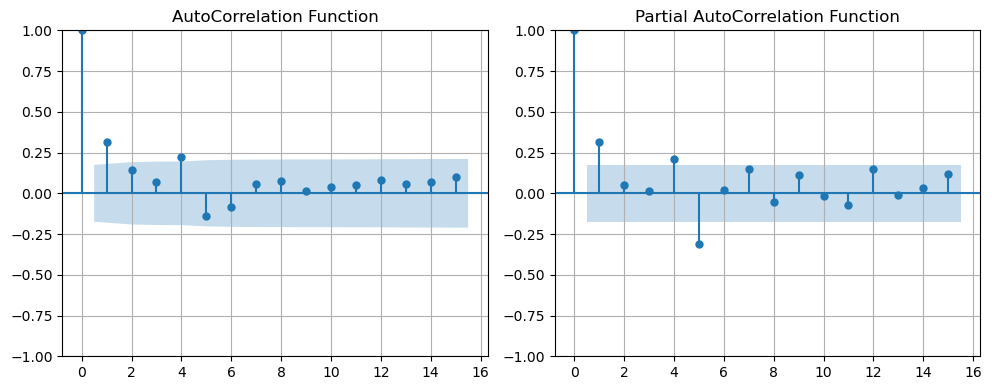

In [21]:
def acf_and_pacf(series, lagsn=15):

    # Create a 1x2 grid for subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

    # Plot AutoCorrelation Function
    plot_acf(series, ax=axes[0], lags=lagsn)
    axes[0].set_title("AutoCorrelation Function", fontsize=12)
    axes[0].grid(True)

    # Plot Partial Autocorrelation Function
    plot_pacf(series, ax=axes[1], lags=lagsn)
    axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


acf_and_pacf(wal_series, lagsn=15)

In [22]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_303 = SARIMAX(wal_series,                     # Time series data
                    order=(3, 0, 3),                # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 3, 4),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_303 = model_303.fit()

# Display summary of the model
print(model_fit_303.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Weekly_Sales   No. Observations:                  126
Model:             SARIMAX(3, 0, 3)x(0, 0, 3, 4)   Log Likelihood               -1469.491
Date:                           Wed, 21 May 2025   AIC                           2958.981
Time:                                   09:57:04   BIC                           2985.986
Sample:                               02-05-2010   HQIC                          2969.935
                                    - 06-29-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2108      0.257      0.821      0.412      -0.292       0.714
ar.L2          0.4321      0.161      2.689

In [23]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_303)

ar.L1 coefficient: 0.2108
ar.L1 95% CI: (-0.2924, 0.7141)
ar.L1 p-value: 0.4116
ar.L1 is statistically IRRELEVANT in the model.

ar.L3 coefficient: 0.3597
ar.L3 95% CI: (-0.0579, 0.7773)
ar.L3 p-value: 0.0914
ar.L3 is statistically IRRELEVANT in the model.

ma.L1 coefficient: 0.2822
ma.L1 95% CI: (-0.1902, 0.7546)
ma.L1 p-value: 0.2417
ma.L1 is statistically IRRELEVANT in the model.

ma.S.L4 coefficient: 0.1031
ma.S.L4 95% CI: (-0.2029, 0.4091)
ma.S.L4 p-value: 0.5091
ma.S.L4 is statistically IRRELEVANT in the model.

ma.S.L8 coefficient: 0.0142
ma.S.L8 95% CI: (-0.2459, 0.2743)
ma.S.L8 p-value: 0.9146
ma.S.L8 is statistically IRRELEVANT in the model.

ma.S.L12 coefficient: 0.0116
ma.S.L12 95% CI: (-0.2901, 0.3134)
ma.S.L12 p-value: 0.9397
ma.S.L12 is statistically IRRELEVANT in the model.



In [24]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_301 = SARIMAX(wal_series,                     # Time series data
                    order=(3, 0, 1),                # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 1, 4),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_301 = model_301.fit()

# Display summary of the model
print(model_fit_301.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Weekly_Sales   No. Observations:                  126
Model:             SARIMAX(3, 0, 1)x(0, 0, 1, 4)   Log Likelihood               -1606.746
Date:                           Wed, 21 May 2025   AIC                           3225.493
Time:                                   09:57:05   BIC                           3242.218
Sample:                               02-05-2010   HQIC                          3232.285
                                    - 06-29-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2869      0.110     11.671      0.000       1.071       1.503
ar.L2         -0.3931      0.193     -2.041

In [25]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_301)

ar.L3 coefficient: 0.1059
ar.L3 95% CI: (-0.1111, 0.3228)
ar.L3 p-value: 0.3389
ar.L3 is statistically IRRELEVANT in the model.



In [26]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_201 = SARIMAX(wal_series,                     # Time series data
                    order=(2, 0, 1),                # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 1, 4),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_201 = model_201.fit()

# Display summary of the model
print(model_fit_201.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Weekly_Sales   No. Observations:                  126
Model:             SARIMAX(2, 0, 1)x(0, 0, 1, 4)   Log Likelihood               -1607.263
Date:                           Wed, 21 May 2025   AIC                           3224.526
Time:                                   09:57:05   BIC                           3238.464
Sample:                               02-05-2010   HQIC                          3230.186
                                    - 06-29-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2527      0.099     12.716      0.000       1.060       1.446
ar.L2         -0.2533      0.099     -2.566

In [27]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_201)

All variables are statistically relevant.


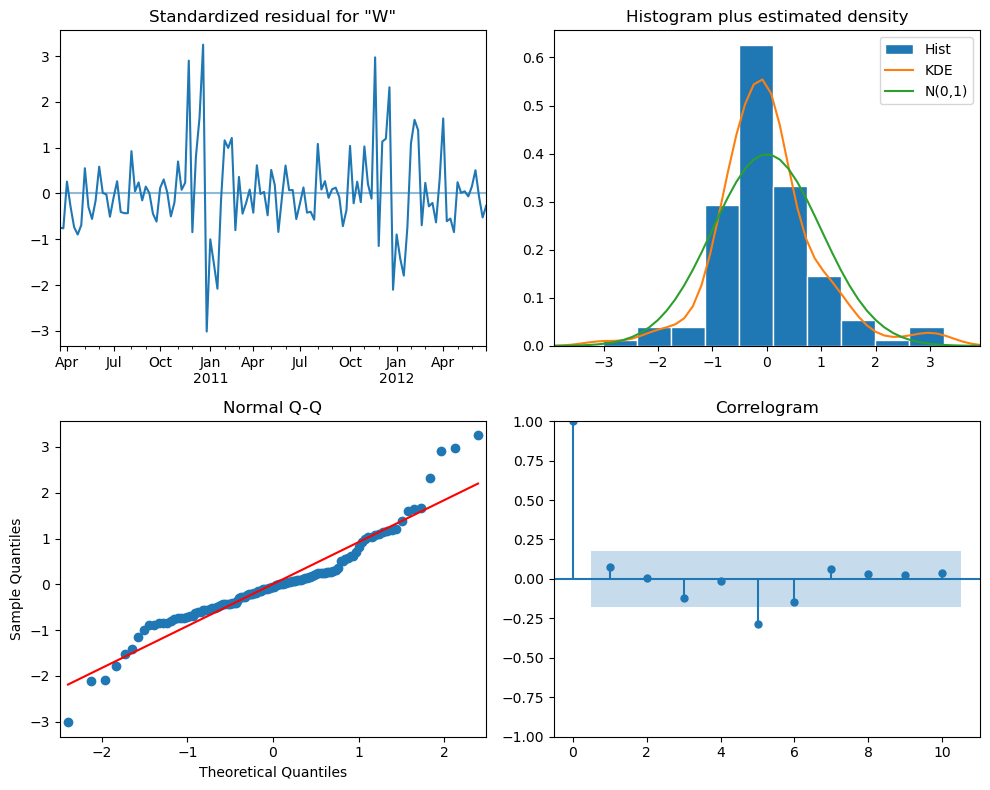

In [28]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_201.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [29]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_201.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.027646,0.867945
2,0.067336,0.966893
3,2.813931,0.421212
4,2.971390,0.562624
5,7.082422,0.214582
6,7.941757,0.242401
7,7.980470,0.334319
8,8.340093,0.400973
9,8.417942,0.492637
10,8.418059,0.588072


In [30]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.5465
Conclusion: No significant autocorrelation.


In [31]:
# Forecast the next Time points
forecast_S = model_fit_201.get_forecast(steps=test.shape[0])

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()        

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values                 # Forecast mean

test['Error S'] = test['Forecast S'] - test['Weekly_Sales']

test['Lower 95% CI S'] = conf_int_S.iloc[:, 0].values       # Lower bound
test['Upper 95% CI S'] = conf_int_S.iloc[:, 1].values       # Upper bound

# Show the updated test DataFrame
test.head()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
Date,,,,,,,,,,
2012-07-06,1769854.16,0,81.57,3.227,221.883779,6.908,1.599118e+06,-170735.792187,1.261784e+06,1.936453e+06
2012-07-13,1527014.04,0,77.12,3.256,221.924158,6.908,1.589586e+06,62571.787693,1.225047e+06,1.954124e+06
2012-07-20,1497954.76,0,80.42,3.311,221.932727,6.908,1.564313e+06,66358.201494,1.189389e+06,1.939237e+06
2012-07-27,1439123.71,0,82.66,3.407,221.941295,6.908,1.565061e+06,125937.177400,1.182754e+06,1.947368e+06
2012-08-03,1631135.79,0,86.11,3.417,221.949864,6.908,1.574769e+06,-56367.127937,1.158981e+06,1.990557e+06


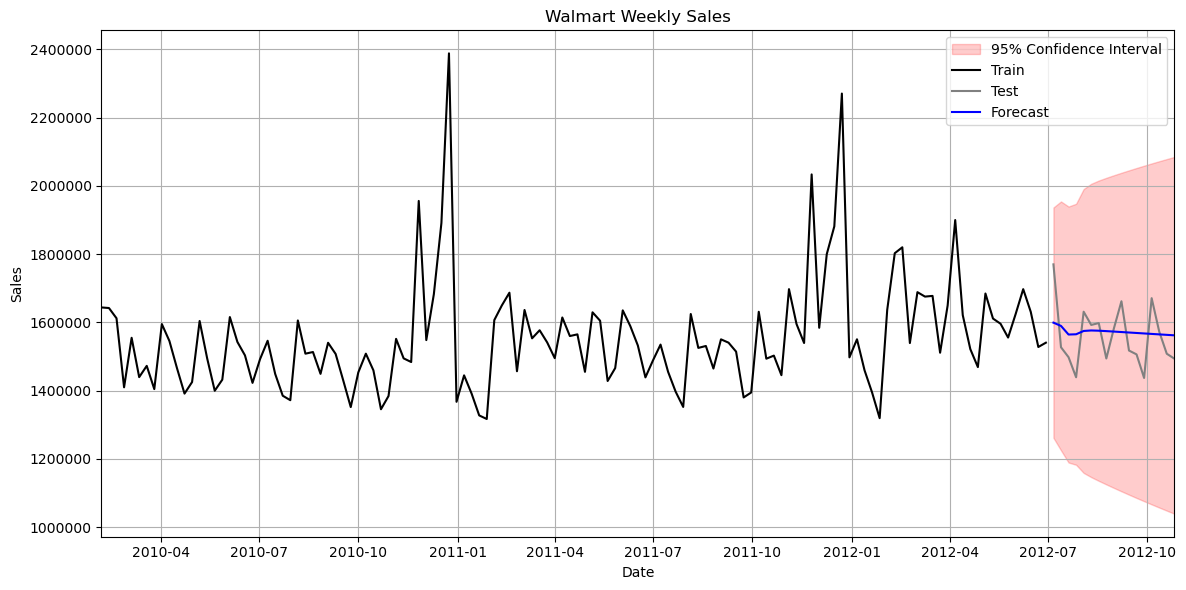

In [32]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Weekly_Sales'], label='Train', color='black')   # Train
plt.plot(test.index, test['Weekly_Sales'], label='Test', color='gray')       # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Walmart Weekly Sales')                      
plt.xlabel('Date')                                        
plt.ylabel('Sales')  
plt.xlim(pd.to_datetime('2010-02-05'), pd.to_datetime('2012-10-26'))
plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

# SARIMAX Model with Exogenous Variables

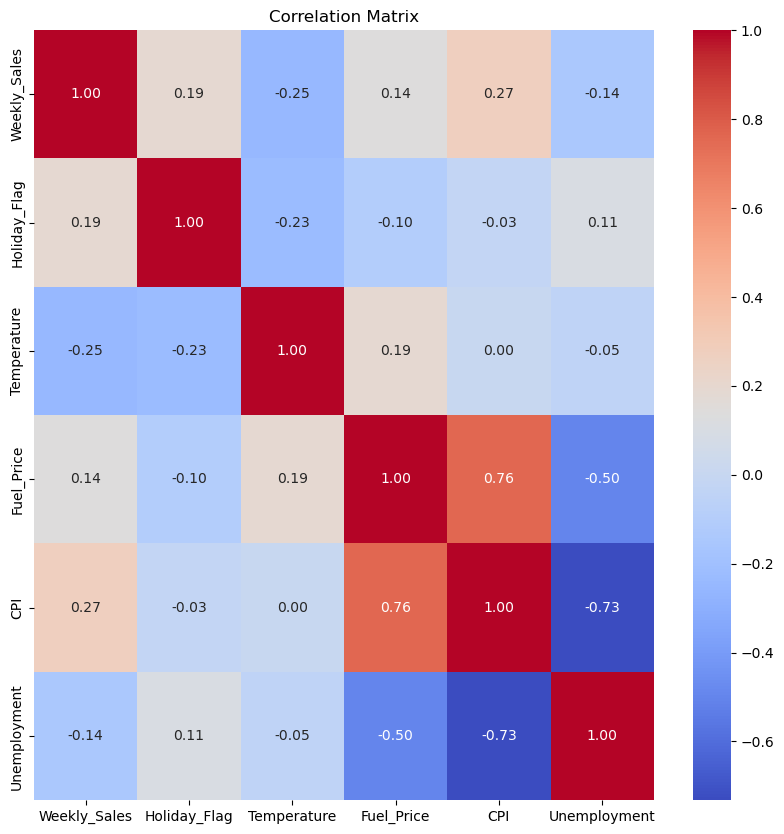

In [33]:
# Compute correlation matrix
c_matrix = train.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [34]:
# Identify columns where the first row value is >= 0.2 or <= -0.2
selected_columns = c_matrix.columns[np.logical_or(c_matrix.iloc[0] >= 0.20, 
                                                  c_matrix.iloc[0] <= -0.20)]

# Convert to list and remove target series
filtered_columns = [col for col in selected_columns if col != 'Weekly_Sales']

# Show the result
print(filtered_columns)

['Temperature', 'CPI']


In [35]:
# Create candidates dataframe
candidates = train[filtered_columns]

# Compute correlation matrix
corr_candidates = candidates.corr()

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = corr_candidates.columns
vif_data["VIF"] = [round(variance_inflation_factor(corr_candidates.values, i), 2) for i in range(len(corr_candidates.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = corr_candidates.corr().round(2)
print(f'Correlation:\n{corr}')

             VIF         Interpretation
Feature                                
Temperature  1.0  Not Multicollinearity
CPI          1.0  Not Multicollinearity

Correlation:
             Temperature  CPI
Temperature          1.0 -1.0
CPI                 -1.0  1.0


In [37]:
# Multiple column selection
exog_data = train[['Temperature', 'CPI']]  

# Target variable selection
endog_data = train['Weekly_Sales']        

In [38]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(2, 0, 1),               
                  seasonal_order=(0, 0, 1, 4),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Weekly_Sales   No. Observations:                  126
Model:             SARIMAX(2, 0, 1)x(0, 0, 1, 4)   Log Likelihood               -1590.882
Date:                           Wed, 21 May 2025   AIC                           3195.764
Time:                                   09:57:05   BIC                           3215.277
Sample:                               02-05-2010   HQIC                          3203.689
                                    - 06-29-2012                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature -2837.8721   1430.642     -1.984      0.047   -5641.878     -33.866
CPI          8114.1702    421.619     19

In [39]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_M)

All variables are statistically relevant.


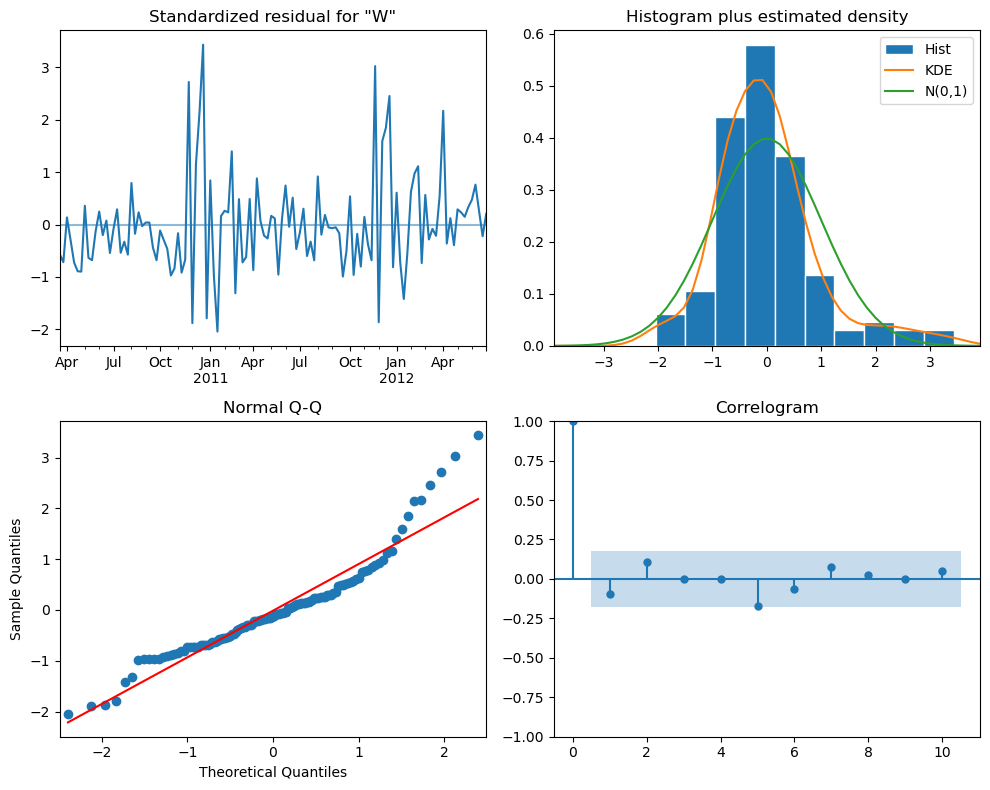

In [40]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [41]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,1.034766,0.309042
2,2.952973,0.228439
3,2.954939,0.398625
4,2.986391,0.560105
5,6.634326,0.249287
6,6.980655,0.322640
7,8.020563,0.330784
8,8.178069,0.416272
9,8.213017,0.512830
10,8.523469,0.577844


In [42]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 2.1749
Conclusion: No significant autocorrelation.


In [43]:
# Must match the structure of training exog
exog_test_M = test[['Temperature', 'CPI']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=test.shape[0], exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['Weekly_Sales']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
Date,,,,,,,,,,,,,,
2012-07-06,1769854.16,0,81.57,3.227,221.883779,6.908,1.599118e+06,-170735.792187,1.261784e+06,1.936453e+06,1.571151e+06,-198703.587837,1.277415e+06,1.864886e+06
2012-07-13,1527014.04,0,77.12,3.256,221.924158,6.908,1.589586e+06,62571.787693,1.225047e+06,1.954124e+06,1.562883e+06,35869.399215,1.251527e+06,1.874239e+06
2012-07-20,1497954.76,0,80.42,3.311,221.932727,6.908,1.564313e+06,66358.201494,1.189389e+06,1.939237e+06,1.512744e+06,14789.514994,1.199561e+06,1.825928e+06
2012-07-27,1439123.71,0,82.66,3.407,221.941295,6.908,1.565061e+06,125937.177400,1.182754e+06,1.947368e+06,1.533120e+06,93996.368272,1.204573e+06,1.861667e+06
2012-08-03,1631135.79,0,86.11,3.417,221.949864,6.908,1.574769e+06,-56367.127937,1.158981e+06,1.990557e+06,1.534300e+06,-96836.254131,1.202785e+06,1.865814e+06


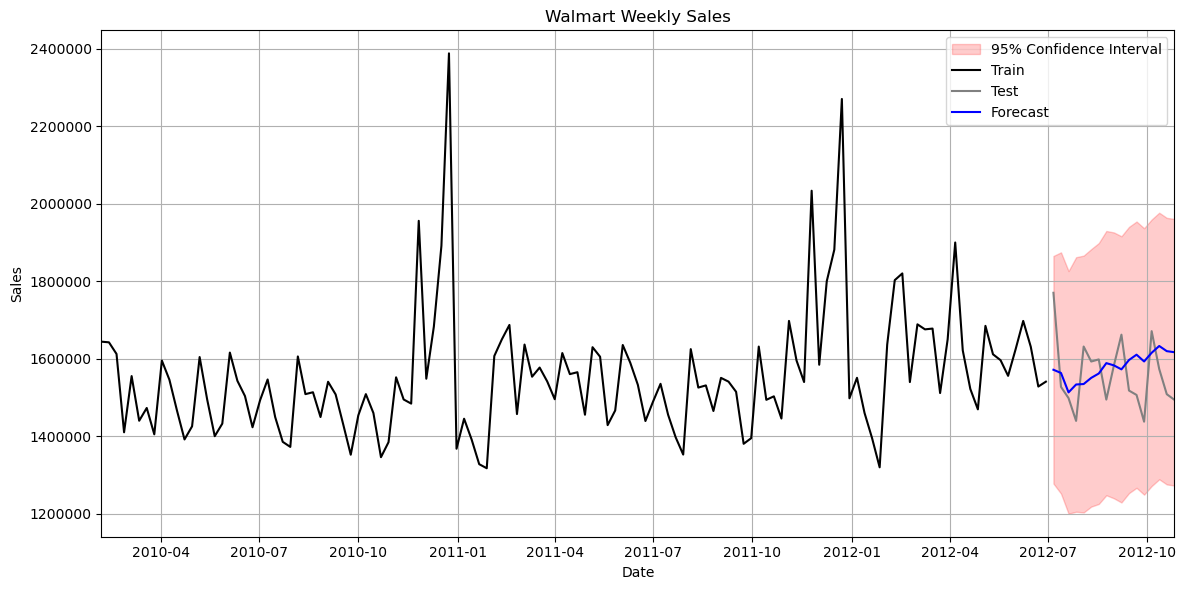

In [44]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Weekly_Sales'], label='Train', color='black')   # Train
plt.plot(test.index, test['Weekly_Sales'], label='Test', color='gray')       # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')     # Forecast

plt.title('Walmart Weekly Sales')                      
plt.xlabel('Date')                                        
plt.ylabel('Sales')  
plt.xlim(pd.to_datetime('2010-02-05'), pd.to_datetime('2012-10-26'))
plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast without Exo
mae_s = mean_absolute_error(test['Weekly_Sales'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['Weekly_Sales'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['Weekly_Sales'], test['Forecast S']) * 100

# Metrics for Forecast with Exo
mae_m = mean_absolute_error(test['Weekly_Sales'], test['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test['Weekly_Sales'], test['Forecast M']))
mape_m = mean_absolute_percentage_error(test['Weekly_Sales'], test['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    #'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    #'MAPE': mape_m,
}

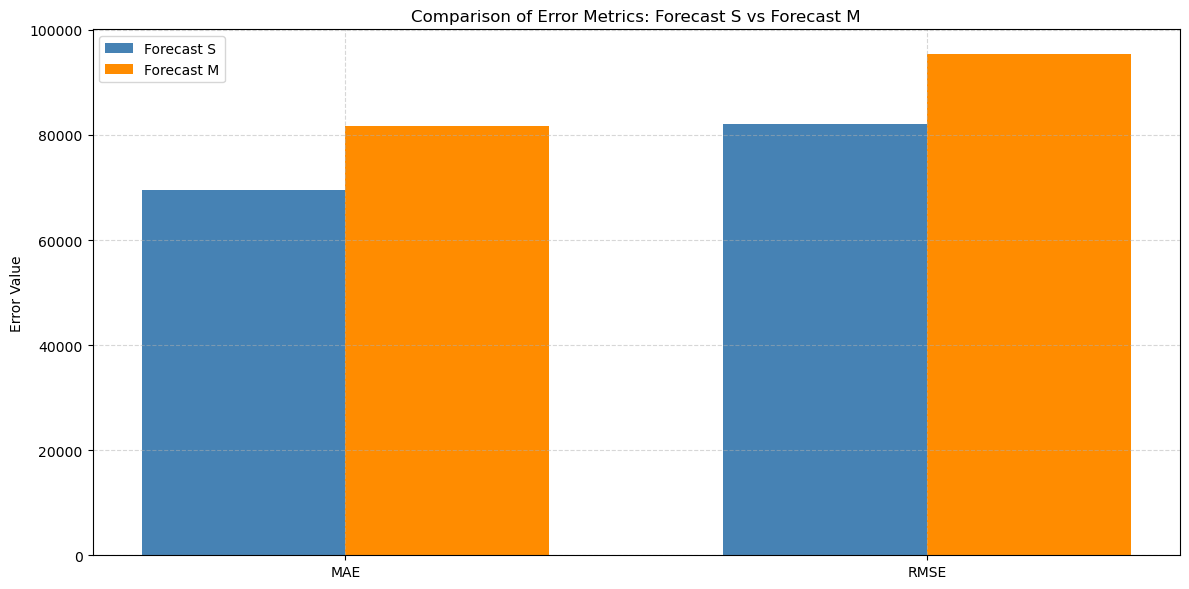

In [46]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [47]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,69564.76,81792.37
RMSE,82034.16,95329.61


In [48]:
from sklearn.metrics import mean_absolute_percentage_error

# MAPE
mape_s = mean_absolute_percentage_error(test['Weekly_Sales'], test['Forecast S']) * 100
mape_m = mean_absolute_percentage_error(test['Weekly_Sales'], test['Forecast M']) * 100

# Create DataFrame for Error Analysis
comparison_mape = pd.DataFrame([mape_s, mape_m], index=['MAPE S', 'MAPE M']).T.round(2) 
comparison_mape

,MAPE S,MAPE M
0,4.47,5.25


On average, the single model's predictions are off by 4.47%, while the predictions from the model with exogenous data are off by 5.25%.

This is probably due to the correlation values of the exogenous variables (−0.25 and 0.27), which add little value to the model and may hinder its performance.

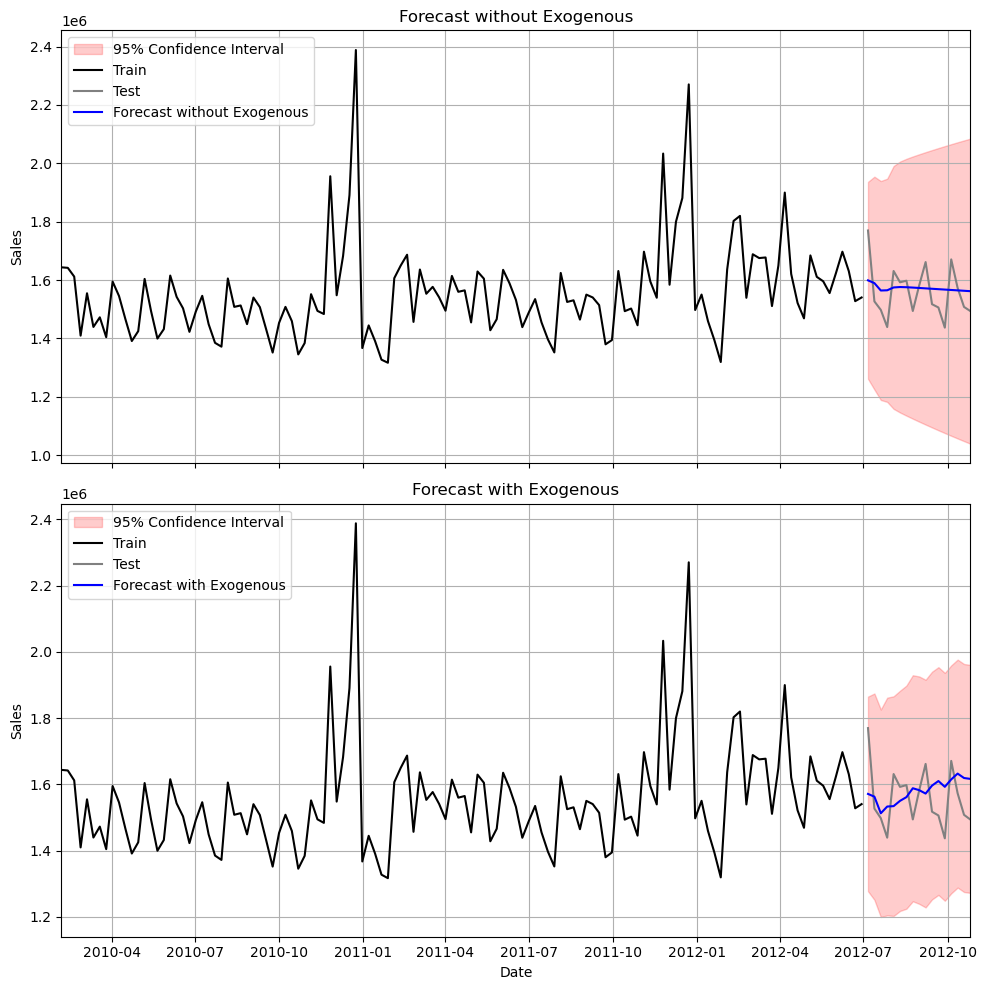

In [49]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast S) ---
axes[0].fill_between(test.index,
                     conf_int_S.iloc[:, 0],
                     conf_int_S.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['Weekly_Sales'], label='Train', color='black')
axes[0].plot(test.index, test['Weekly_Sales'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast without Exogenous', color='blue')

axes[0].set_title('Forecast without Exogenous')
axes[0].set_ylabel('Sales')
axes[0].legend(loc=2)
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('2010-02-05'), pd.to_datetime('2012-10-26'))
#axes[0].set_ylim(0, 60)

# --- Second Forecast (Forecast M) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train.index, train['Weekly_Sales'], label='Train', color='black')
axes[1].plot(test.index, test['Weekly_Sales'], label='Test', color='gray')
axes[1].plot(test.index, test['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales')
axes[1].legend(loc=2)
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('2010-02-05'), pd.to_datetime('2012-10-26'))
#axes[1].set_ylim(0, 60)

# Final layout
plt.tight_layout()
plt.show()

End.